### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'osha_accidents',
    'source': 'kaggle', # ['kaggle', 'local', 'openml', 'hf']
    'remote_path': 'ruqaiyaship/osha-accident-and-injury-data-1517',
    'files': ['OSHA HSE DATA_ALL ABSTRACTS 15-17_FINAL.csv'],
    'rename_files': ['osha_data.csv'],
    'task': 'clf', # ['reg', 'clf']
    'target': 'Task Assigned',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/osha_accidents.
Downloaded osha_accidents dataset to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/osha_accidents


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/osha_accidents/osha_data.csv


,summary_nr,Event Date,Abstract Text,Event Description,Event Keywords,con_end,Construction End Use,build_stor,Building Stories,proj_cost,Project Cost,proj_type,Project Type,Degree of Injury,nature_of_inj,Nature of Injury,part_of_body,Part of Body,event_type,Event type,evn_factor,Environmental Factor,hum_factor,Human Factor,task_assigned,Task Assigned,hazsub,fat_cause,fall_ht
0,220982664,8/10/2017,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",0,,0,,0,,0,,Nonfatal,1,"Amputation, Crushing",10,Fingers,2,Caught in or between,2,Catch Point/Puncture Action,14,Other,1,Regularly Assigned,0,0,0
1,220973937,7/17/2017,"At 9:45 a.m. on July 17, 2017, an employee was...",EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...,"CAUGHT IN,DRIVE SHAFT,RESIDENTIAL CONSTRUCTION...",H,Other building,1,1,0,,B,Alteration or rehabilitation,Nonfatal,9,Dislocation,10,Fingers,2,Caught in or between,18,Other,10,Position Inappropriate For Task,1,Regularly Assigned,0,0,0
2,220967632,6/30/2017,"At 7:30 a.m. on June 30, 2017, an employee was...",EMPLOYEE IS HOSPITALIZED AFTER BEING INJURED I...,"AMPUTATED,EXPLOSION,FIREWORKS",0,,0,,0,,0,,Nonfatal,5,Fire Burn,12,Hand,14,Other,18,Other,4,Malfunction In Securing/Warning Op,2,Not Regularly Assigned,0,0,0


In [6]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.5 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index([], dtype='object')
Dataframe shape before/afrer cleaning: (4847, 29) / (4847, 28)


In [18]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['summary_nr','proj_cost',
    'proj_type', 'nature_of_inj', 'part_of_body', 'event_type',
    'evn_factor', 'hum_factor','task_assigned']

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

dataset_files_cleaned[0].head(n=3)

Column summary_nr not found in dataframe
Dataframe shape before/afrer by-hand cleaning: (4847, 27) / (4847, 19)


,Event Date,Abstract Text,Event Description,Event Keywords,con_end,Construction End Use,build_stor,Building Stories,Project Cost,Project Type,Degree of Injury,Nature of Injury,Part of Body,Event type,Environmental Factor,Human Factor,Task Assigned,hazsub,fat_cause
0,1.502323e+09,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",0,,0,,,,Nonfatal,"Amputation, Crushing",Fingers,Caught in or between,Catch Point/Puncture Action,Other,Regularly Assigned,0,0
1,1.500250e+09,"At 9:45 a.m. on July 17, 2017, an employee was...",EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...,"CAUGHT IN,DRIVE SHAFT,RESIDENTIAL CONSTRUCTION...",H,Other building,1,1,,Alteration or rehabilitation,Nonfatal,Dislocation,Fingers,Caught in or between,Other,Position Inappropriate For Task,Regularly Assigned,0,0
2,1.498781e+09,"At 7:30 a.m. on June 30, 2017, an employee was...",EMPLOYEE IS HOSPITALIZED AFTER BEING INJURED I...,"AMPUTATED,EXPLOSION,FIREWORKS",0,,0,,,,Nonfatal,Fire Burn,Hand,Other,Other,Malfunction In Securing/Warning Op,Not Regularly Assigned,0,0


In [19]:
# TODO: some custom data cleaning

import copy 
import pandas as pd

tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    
    # 1. Convert 'Event Date' to timestamp (safe handling for NaT)
    df_file['Event Date'] = pd.to_datetime(df_file['Event Date'], format='%m/%d/%Y', errors='coerce')
    df_file['Event Date'] = df_file['Event Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else float('nan'))

    print(f"Dataframe shape after custom cleaning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# reset the dataframe list to the version before custom cleaning -> next cells work with dataset_files_by_hand_cleaned
dataset_files_cleaned = tmp_df


Dataframe shape before custom cleaning: (4847, 19)
Dataframe shape after custom cleaning: (4847, 19)


### Now it is time to visualize our changes

In [20]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,Event Date,Abstract Text,Event Description,Event Keywords,con_end,Construction End Use,build_stor,Building Stories,Project Cost,Project Type,Degree of Injury,Nature of Injury,Part of Body,Event type,Environmental Factor,Human Factor,Task Assigned,hazsub,fat_cause
0,NaN,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",0,,0,,,,Nonfatal,"Amputation, Crushing",Fingers,Caught in or between,Catch Point/Puncture Action,Other,Regularly Assigned,0,0
1,NaN,"At 9:45 a.m. on July 17, 2017, an employee was...",EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...,"CAUGHT IN,DRIVE SHAFT,RESIDENTIAL CONSTRUCTION...",H,Other building,1,1,,Alteration or rehabilitation,Nonfatal,Dislocation,Fingers,Caught in or between,Other,Position Inappropriate For Task,Regularly Assigned,0,0
2,NaN,"At 7:30 a.m. on June 30, 2017, an employee was...",EMPLOYEE IS HOSPITALIZED AFTER BEING INJURED I...,"AMPUTATED,EXPLOSION,FIREWORKS",0,,0,,,,Nonfatal,Fire Burn,Hand,Other,Other,Malfunction In Securing/Warning Op,Not Regularly Assigned,0,0


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [21]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (1): ['hazsub']
Categorical columns (15): ['Event Date', 'con_end', 'Construction End Use', 'build_stor', 'Building Stories', 'Project Cost', 'Project Type', 'Degree of Injury', 'Nature of Injury', 'Part of Body', 'Event type', 'Environmental Factor', 'Human Factor', 'Task Assigned', 'fat_cause']
Textual columns (3): ['Abstract Text', 'Event Description', 'Event Keywords']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [14]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

display(summary_df)  # Or print(summary_df)


,Column Name,Example Value,Type,# Categories
0,Event Date,1502323200.0,numerical,~ 671 ~
1,Abstract Text,"At 9:00 a.m. on August 10, 2017, an employee w...",textual,4829
2,Event Description,EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,textual,4320
3,Event Keywords,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",textual,4427
4,con_end,0,categorical,18
5,Construction End Use,,categorical,18
6,build_stor,0,categorical,25
7,Building Stories,,categorical,25
8,proj_cost,0,categorical,8
9,Project Cost,,categorical,8


### Saving the processed data and loading it back up

In [ ]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{dataset_config['dataset_name']}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping save.")
        continue

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/osha_accidents/osha_data_processed.pkl


In [ ]:
import os
import pandas as pd

import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( "..", "..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from configs.dataset_configs import get_a_dataset_dict

print(dataset_config['dataset_name'])

loaded_dataset_config = get_a_dataset_dict(dataset_config['dataset_name'])

file_base = loaded_dataset_config['name']
processed_filename = f"{file_base}_processed.pkl"
processed_path = os.path.join(download_path, processed_filename)

# Load the bundled dictionary (data + summary + config)
bundle = pd.read_pickle(processed_path)

# Extract components
loaded_df = bundle['data']
summary_df = bundle['summary']
loaded_config = bundle['config']

print(f"\n=== {file_base.upper()} ===")
print(f"Loaded config keys: {list(loaded_config.keys())}")

# Show metadata
meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
display(meta_df)

# Flatten for modeling
loaded_df.columns = loaded_df.columns.get_level_values(0)
display(loaded_df.head(n=3))



=== OSHA_DATA ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Event Date,numerical,~ 671 ~
1,Abstract Text,textual,4829
2,Event Description,textual,4320
3,Event Keywords,textual,4427
4,con_end,categorical,18
5,Construction End Use,categorical,18
6,build_stor,categorical,25
7,Building Stories,categorical,25
8,proj_cost,categorical,8
9,Project Cost,categorical,8


Column Name,Event Date,Abstract Text,Event Description,Event Keywords,con_end,Construction End Use,build_stor,Building Stories,proj_cost,Project Cost,proj_type,Project Type,Degree of Injury,nature_of_inj,Nature of Injury,part_of_body,Part of Body,event_type,Event type,evn_factor,Environmental Factor,hum_factor,Human Factor,task_assigned,Task Assigned,hazsub,fat_cause
0,1.502323e+09,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",0,,0,,0,,0,,Nonfatal,1,"Amputation, Crushing",10,Fingers,2,Caught in or between,2,Catch Point/Puncture Action,14,Other,1,Regularly Assigned,0,0
1,1.500250e+09,"At 9:45 a.m. on July 17, 2017, an employee was...",EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...,"CAUGHT IN,DRIVE SHAFT,RESIDENTIAL CONSTRUCTION...",H,Other building,1,1,0,,B,Alteration or rehabilitation,Nonfatal,9,Dislocation,10,Fingers,2,Caught in or between,18,Other,10,Position Inappropriate For Task,1,Regularly Assigned,0,0
2,1.498781e+09,"At 7:30 a.m. on June 30, 2017, an employee was...",EMPLOYEE IS HOSPITALIZED AFTER BEING INJURED I...,"AMPUTATED,EXPLOSION,FIREWORKS",0,,0,,0,,0,,Nonfatal,5,Fire Burn,12,Hand,14,Other,18,Other,4,Malfunction In Securing/Warning Op,2,Not Regularly Assigned,0,0


### Bonus insights (Classification)

Text(0.5, 1.0, "Distribution of 'Task Assigned' target")

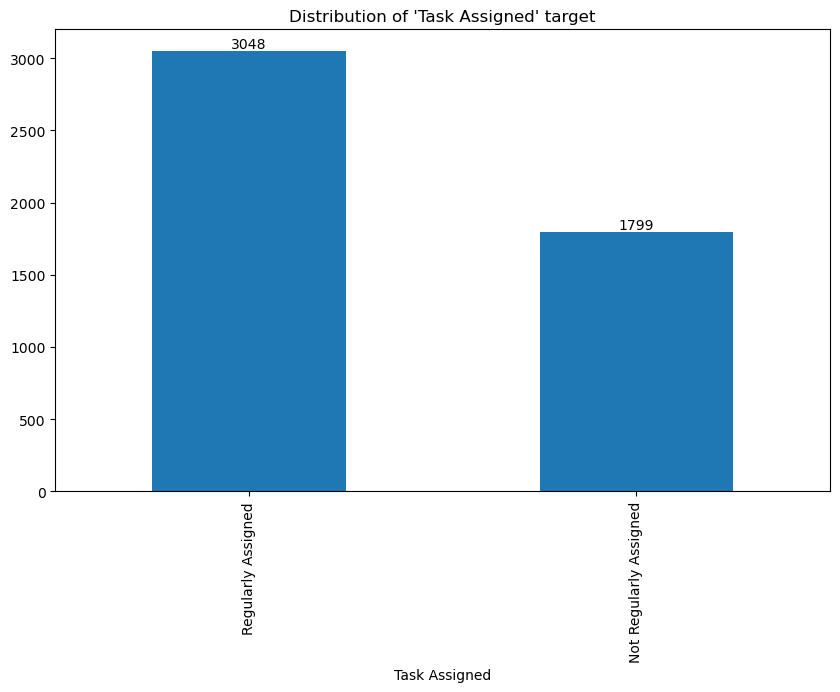

In [17]:
# show data imbalance:
import matplotlib.pyplot as plt

# Plot the distribution of player_class with counts
value_counts = loaded_df[dataset_config['target']].value_counts()

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')

# Add counts as text labels on top of bars
for i, count in enumerate(value_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title(f"Distribution of '{dataset_config['target']}' target")

